## Trabajo Práctico: Red Neuronal Lineal.

Nota: aca en el notebook usamos algunas funciones como @, qr, de NP solo para comparar con
los resultados correctos (calculados con numpy). Las soluciones a todos los sistemas verdaderos y las implementaciones de
todas las funciones nuestras implementan cada una de estas operaciones a mano (en el alc.py).

Lo que si, usamos las funciones np.sum, np.min, np.max para poder vectorizar cuentas que si no tardaban mucho,
como prodint() que se usa en nuestra multiplicacion de matrices

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FormatStrFormatter
import os
import time

sys.path.append(".")
sys.path.append("./TP")
from alc import *



np.set_printoptions(precision=3, linewidth=150, suppress=True)

os.getcwd()[-3:]
tol = 0.01



/home/leneth/code/TpYLabosAlc/TP/alc.py:348: SyntaxWarning: invalid escape sequence '\{'
  Devuelve la norma ||A||\{q,p} y el vector x en el cual se alcanza


Cargamos el dataset

Recordamos, los "t" son los valores de entrenamiento, y los v son los de testeo

In [2]:
Xt, Yt, Xv, Yv = cargarDataset("cats_and_dogs") 
#Xt, Yt, Xv, Yv =  cargarDatasetReducido("cats_and_dogs", 500, 500)
print(Xt.shape)
print(Xv.shape)
print(Yt[:,:3], Yt.shape)
print(Yt[:,:3], Yv.shape)

(1536, 2000)
(1536, 1000)
[[0 0 0]
 [1 1 1]] (2, 2000)
[[0 0 0]
 [1 1 1]] (2, 1000)


In [3]:
cache_save_enabled = False
cache_load_enabled = False

def cache(calc, name):
    if cache_load_enabled and os.path.isfile(f"{name}.npy"):
        return np.load(f"{name}.npy", allow_pickle=True)
    else:
        val = calc()
        if cache_save_enabled:
            np.save(f"{name}.npy", val, allow_pickle=True)
        return val

def cache_many(calc, names):
    if cache_load_enabled and all([os.path.isfile(f"{name}.npy") for name in names]):
        return tuple([cache(lambda:None, name) for name in names])
    else:
        vals = calc()
        for name, val in zip(names, vals):
            cache(lambda:val, name)
        return vals
    
# no quiero perder horas de computo pq fallo un assert, armo esto para que si "Fallaría" el assert te avisa
def pseudoAssertEquality(X,Y, atol = tol):
    try:
        assert np.allclose(X,Y, atol=tol)
    except:
        print("WARNING: Necesita tolerancia ", np.max(np.abs(X-Y)))
    

### QR
Tuvimos que cambiar la funcion de QR del labo para que acepte matrices no cuadradas.
  
Queremos no tener que volver a hacer cuentas muy largas mientras testeamos. QR por GS no es lento asi que no es tan necesario, pero lo hacemos empezando aca por consistencia

#### Por Gram schmidt

In [ ]:
tiempogs = datetime.now()
QGS, RGS = cache_many(lambda: QR_con_GS(traspuesta(Xt)), ["QGS", "RGS"])

WGS = cache(lambda:pinvGramSchmidt(QGS,RGS,Yt), "WGS")

YvProbabilidadesGS = cache(lambda:matmul(WGS, Xv), "YvEsperadosGS")




ortonormalizando 100-esimo vector de 1536 a las 23:14:57.479609
ortonormalizando 200-esimo vector de 1536 a las 23:14:57.810512
ortonormalizando 300-esimo vector de 1536 a las 23:14:58.251548
ortonormalizando 400-esimo vector de 1536 a las 23:14:58.807103
ortonormalizando 500-esimo vector de 1536 a las 23:14:59.477492
ortonormalizando 600-esimo vector de 1536 a las 23:15:00.253365
ortonormalizando 700-esimo vector de 1536 a las 23:15:01.132871
ortonormalizando 800-esimo vector de 1536 a las 23:15:02.162001
ortonormalizando 900-esimo vector de 1536 a las 23:15:03.261705
ortonormalizando 1000-esimo vector de 1536 a las 23:15:04.478237
ortonormalizando 1100-esimo vector de 1536 a las 23:15:05.800134
ortonormalizando 1200-esimo vector de 1536 a las 23:15:07.264426
ortonormalizando 1300-esimo vector de 1536 a las 23:15:08.855851
ortonormalizando 1400-esimo vector de 1536 a las 23:15:10.556422
ortonormalizando 1500-esimo vector de 1536 a las 23:15:12.360646
<class 'numpy.ndarray'> <class 'nu

In [ ]:
tiempofinalgs = datetime.now()
# compotamiento extraño si cacheas algo que no es una lista
tiempototalgs = cache(lambda: np.array([tiempofinalgs - tiempogs]), "tiempototalGS").item()
print("Tardo:", (tiempofinalgs-tiempogs).seconds, "segundos")

Tardo: 42 segundos


In [ ]:


## comparemos con funcion numpy por si a caso
QNP,RNP = cache_many(lambda: np.linalg.qr(traspuesta(Xt)), ["QNP", "RNP"])

Nump=True
YvProbabilidadesNPQR = cache(lambda:pinvGramSchmidt(QNP,RNP,Yt) @ Xv, "YvEsperadosNPQR")
Nump=False

pseudoAssertEquality(YvProbabilidadesGS,  YvProbabilidadesNPQR, atol=tol)




<class 'numpy.ndarray'> <class 'numpy.ndarray'>
listo resolviendo sistema
listo trasponiendo
Calculando W


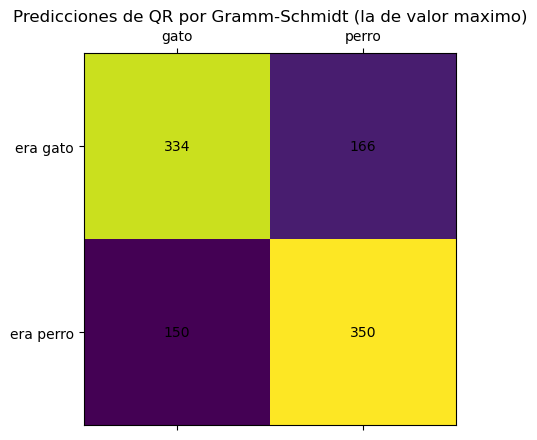

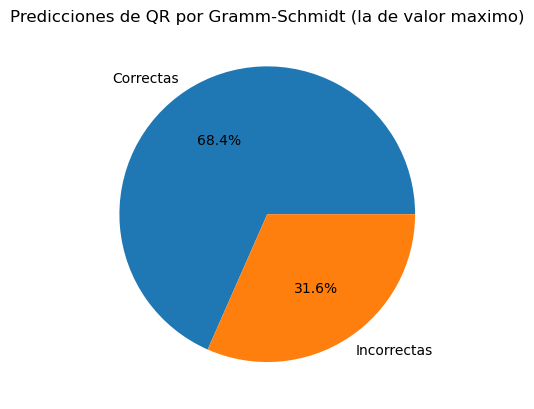

In [ ]:
# medio feo tener un choclo de codigo aca pero peor era tener que importar matplotlib en ALC.py  
def graficar_predicciones_de_metodo(nombre_metodo, predicciones, valores_reales):
    gato = [1,0]
    perro = [0,1]


    posibilidadesNombres = ["gato", "perro"]
    confusion2 = np.zeros((2,2))
    for prediccion, valorCorrecto in zip(  traspuesta(predicciones) , traspuesta(valores_reales) ):
        indiceY = int(1-valorCorrecto[0])
        indiceX = int(max(prediccion) == prediccion[1])
        confusion2[ indiceY ][ indiceX ] += 1

    
    
    plt.matshow(confusion2)
    plt.title(f"Predicciones de {nombre_metodo} (la de valor maximo)")
    plt.xticks(range(len(posibilidadesNombres)), posibilidadesNombres)
    plt.yticks(range(len(posibilidadesNombres)), ["era "+n for n in posibilidadesNombres ])
    
    for i ,row in enumerate(confusion2):
        for j ,val in enumerate(row):
            plt.text(j, i, f"{int(val)}", ha="center", va="center", color="black") 
    plt.show()
    pie(confusion2, nombre_metodo + " (la de valor maximo)")

    return confusion2


def pie(confusion, nombre_metodo):
    correcto = 0
    incorrecto = 0
    for i in range(len(confusion)):
        correcto += confusion[i][i]

    incorrecto = len(Xv[0]) - correcto
    plt.pie([correcto, incorrecto], labels=["Correctas", "Incorrectas"], autopct='%1.1f%%')
    plt.title(f"Predicciones de {nombre_metodo}")
    plt.show()

confusionGS = graficar_predicciones_de_metodo("QR por Gramm-Schmidt", YvProbabilidadesGS, Yv)

#### Por HH

In [ ]:
tiempohh = datetime.now()

QHH, RHH = cache_many(lambda: QR_con_HH(traspuesta(Xt)), ["QHH", "RHH"])
WHH = cache(lambda:pinvHouseHolder(QHH,RHH,Yt), "WHH")
YvProbabilidadesHH = cache(lambda:matmul(WHH, Xv), "YvEsperadosHH")




householderizando 0-esima sumbatriz de 1536 a las 23:03:01.317831
householderizando 100-esima sumbatriz de 1536 a las 23:03:10.639753
householderizando 200-esima sumbatriz de 1536 a las 23:03:19.313308
householderizando 300-esima sumbatriz de 1536 a las 23:03:27.460077
householderizando 400-esima sumbatriz de 1536 a las 23:03:34.990631
householderizando 500-esima sumbatriz de 1536 a las 23:03:42.020371
householderizando 600-esima sumbatriz de 1536 a las 23:03:48.593107
householderizando 700-esima sumbatriz de 1536 a las 23:03:54.804926
householderizando 800-esima sumbatriz de 1536 a las 23:04:00.457161
householderizando 900-esima sumbatriz de 1536 a las 23:04:05.706520
householderizando 1000-esima sumbatriz de 1536 a las 23:04:10.758956
householderizando 1100-esima sumbatriz de 1536 a las 23:04:15.435251
householderizando 1200-esima sumbatriz de 1536 a las 23:04:19.684397
householderizando 1300-esima sumbatriz de 1536 a las 23:04:23.654242
householderizando 1400-esima sumbatriz de 1536

In [ ]:

tiempofinalhh = datetime.now()
tiempototalhh = cache(lambda: np.array([tiempofinalhh - tiempohh]), "tiempototalHH").item()
print("Tardo:", (tiempofinalhh-tiempohh).seconds, "segundos")

pseudoAssertEquality(YvProbabilidadesHH,  YvProbabilidadesNPQR, atol=tol)

Tardo: 117 segundos


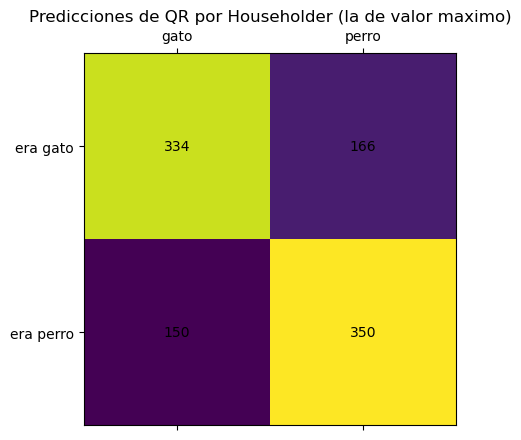

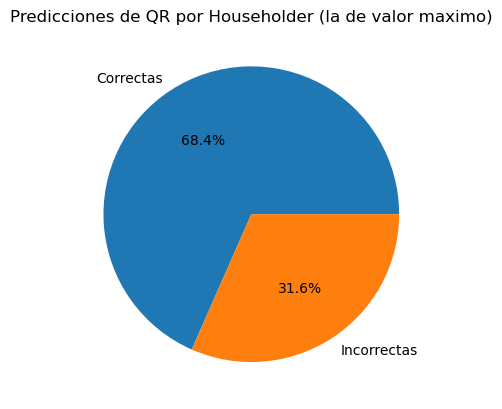

In [ ]:
confusionHH = graficar_predicciones_de_metodo("QR por Householder", YvProbabilidadesHH, Yv)


### SVD

In [ ]:
tiemposvd = datetime.now()

U,S,V = cache_many(lambda: svd_reducida(Xt, tol=tol), ["U","S","V"])

# svd_reducida, como pide su enunciado, devuelve un vector en S. pero pinvSVD tiene que tomar una matriz. 
# generamos la matriz SM
def diagFrom(list, shape):
    res = np.zeros(shape)
    for i,item in  enumerate(list):
        res[i][i] = item
    return res

 

WSVD = cache(lambda:pinvSVD(U,diagFrom(S, Xt.shape),V,Yt), "WSVD")

YvProbabilidadesSVD = cache(lambda:matmul(WSVD, Xv), "YvEsperadosSVD")


diagonalizando 1520-esima sumbatriz a las 23:05:35.098910
diagonalizando 1500-esima sumbatriz a las 23:05:38.205872
diagonalizando 1480-esima sumbatriz a las 23:05:41.855551
diagonalizando 1460-esima sumbatriz a las 23:05:44.911006
diagonalizando 1440-esima sumbatriz a las 23:05:47.888574
diagonalizando 1420-esima sumbatriz a las 23:05:51.072281
diagonalizando 1400-esima sumbatriz a las 23:05:54.063568
diagonalizando 1380-esima sumbatriz a las 23:05:56.837313
diagonalizando 1360-esima sumbatriz a las 23:05:59.629786
diagonalizando 1340-esima sumbatriz a las 23:06:02.625662
diagonalizando 1320-esima sumbatriz a las 23:06:05.228603
diagonalizando 1300-esima sumbatriz a las 23:06:07.805044
diagonalizando 1280-esima sumbatriz a las 23:06:10.770092
diagonalizando 1260-esima sumbatriz a las 23:06:13.219831
diagonalizando 1240-esima sumbatriz a las 23:06:15.669993
diagonalizando 1220-esima sumbatriz a las 23:06:18.301265
diagonalizando 1200-esima sumbatriz a las 23:06:20.568891
diagonalizando

In [ ]:
tiempofinalsvd = datetime.now()
tiempototalsvd = cache(lambda: np.array([tiempofinalsvd - tiemposvd]), "tiempototalSVD").item()

print("Tardo:", (tiempofinalsvd-tiemposvd).seconds, "segundos")

Tardo: 261 segundos


In [ ]:


print(f"W: {np.round(WSVD,3).shape}")
# pseudoAssertEquality(U @ np.diag(S) @ traspuesta(V), Xt, atol=tol)

print(YvProbabilidadesSVD)
print(Yv)

# Generamos un SVD usando numpy para comparar que tan diferente queda comparada con la nuestra 
UNP,SNP,VNP= cache_many(lambda: np.linalg.svd(Xt), ["UNP","SNP","VNP"])
VNP = VNP.T[:,:Xt.shape[0]]

Nump=True
WSVDNP = cache(lambda:pinvSVD(UNP,diagFrom(SNP, Xt.shape),VNP,Yt), "WSVDNP")
YvProbabilidadesSVDNP = cache(lambda:WSVDNP @ Xv, "YvEsperadosSVDNP")
Nump=False

pseudoAssertEquality(YvProbabilidadesSVD, YvProbabilidadesSVDNP, atol=tol)



W: (2, 1536)
[[-0.292  0.108 -0.22  ...  0.383  2.491  0.451]
 [ 1.042  0.208  1.403 ...  0.551 -0.594  0.24 ]]
[[0 0 0 ... 1 1 1]
 [1 1 1 ... 0 0 0]]


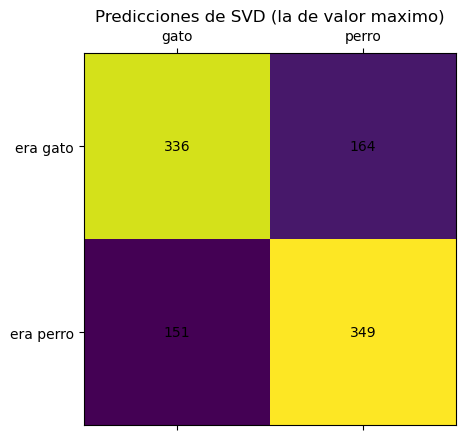

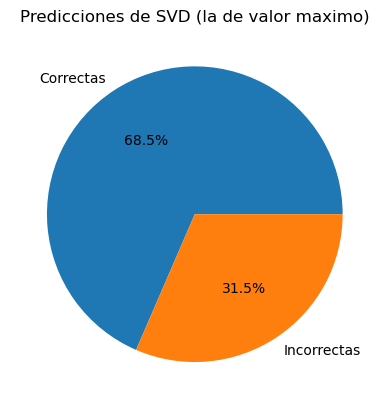

In [ ]:
confusionSVD = graficar_predicciones_de_metodo("SVD", YvProbabilidadesSVD, Yv)

### Cholesky / Ecuaciones Normales

In [ ]:
tiempoeq= datetime.now()

LCholesky = cache(lambda: cholesky(matmul(Xt, traspuesta(Xt))), "LCholesky")

WEqNorm = cache(lambda:pinvEcuacionesNormales(Xt,LCholesky,Yt), "WEN")

YvProbabilidadesEqNorm = cache(lambda:matmul(WEqNorm, Xv), "YvEsperadosEqNorm")






choleskizando 0-esima columna a las 23:10:49.967746
choleskizando 100-esima columna a las 23:10:50.700487
choleskizando 200-esima columna a las 23:10:51.403480
choleskizando 300-esima columna a las 23:10:52.090280
choleskizando 400-esima columna a las 23:10:52.731752
choleskizando 500-esima columna a las 23:10:53.327859
choleskizando 600-esima columna a las 23:10:53.900813
choleskizando 700-esima columna a las 23:10:54.433124
choleskizando 800-esima columna a las 23:10:54.934976
choleskizando 900-esima columna a las 23:10:55.384202
choleskizando 1000-esima columna a las 23:10:55.769749
choleskizando 1100-esima columna a las 23:10:56.114359
choleskizando 1200-esima columna a las 23:10:56.401291
choleskizando 1300-esima columna a las 23:10:56.624497
choleskizando 1400-esima columna a las 23:10:56.789732
choleskizando 1500-esima columna a las 23:10:56.895805
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
tiempofinaleq = datetime.now()
tiempototaleq = cache(lambda: np.array([tiempofinaleq - tiempoeq]), "tiempototalEQ").item()
print("Tardo:", (tiempofinaleq-tiempoeq).seconds, "segundos")

Tardo: 96 segundos


In [ ]:

print(f"W: {np.round(WEqNorm,3).shape}")
# pseudoAssertEquality(LCholesky @ traspuesta(LCholesky), matmul(Xt, traspuesta(Xt)), atol=tol)

print(YvProbabilidadesEqNorm)
print(Yv)

# comparamos con el resultado de hacerlo con numpy
LCholeskyNP = cache(lambda:  np.linalg.cholesky(Xt @ Xt.T), "LCholeskyNP")

Nump=True
WWEqNormNP = cache(lambda:pinvEcuacionesNormales(Xt, LCholeskyNP, Yt), "WENNP")
YvProbabilidadesEqNormNP = cache(lambda:WWEqNormNP @ Xv, "YvEsperadosEqNormNP")
Nump=False


W: (2, 1536)
[[-0.253  0.005 -0.255 ...  0.402  2.461  0.403]
 [ 1.027  0.345  1.371 ...  0.507 -0.557  0.306]]
[[0 0 0 ... 1 1 1]
 [1 1 1 ... 0 0 0]]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


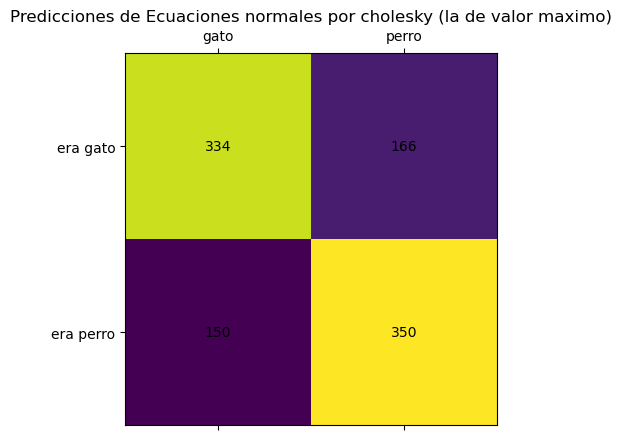

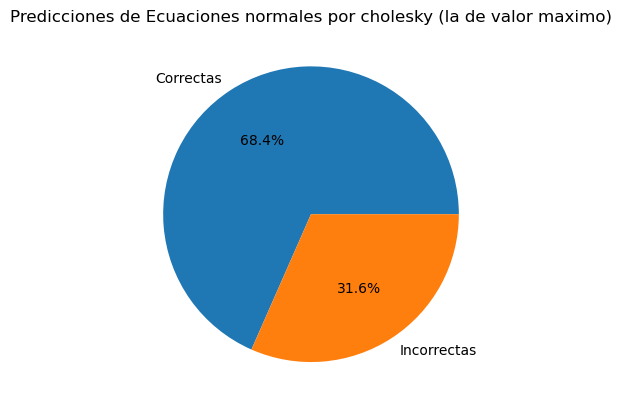

In [ ]:
confusionEQ = graficar_predicciones_de_metodo("Ecuaciones normales por cholesky", YvProbabilidadesEqNorm, Yv)

## Analisis de datos

In [ ]:
difProbabilidadesGR=np.max(np.abs(YvProbabilidadesGS-YvProbabilidadesNPQR))
difProbabilidadesHH=np.max(np.abs(YvProbabilidadesHH-YvProbabilidadesNPQR))
difProbabilidadesEqNorm=np.max(np.abs(YvProbabilidadesEqNorm-YvProbabilidadesEqNormNP))
difProbabilidadesSVD=np.max(np.abs(YvProbabilidadesSVD-YvProbabilidadesSVDNP))

avgDifProbabilidadesGR=np.average(np.abs(YvProbabilidadesGS-YvProbabilidadesNPQR))
avgDifProbabilidadesHH=np.average(np.abs(YvProbabilidadesHH-YvProbabilidadesNPQR))
avgDifProbabilidadesEqNorm=np.average(np.abs(YvProbabilidadesEqNorm-YvProbabilidadesEqNormNP))
avgDifProbabilidadesSVD=np.average(np.abs(YvProbabilidadesSVD-YvProbabilidadesSVDNP))

exactitudGs = (confusionGS[0][0]+confusionGS[1][1])/(confusionGS[0][0]+confusionGS[1][1] + confusionGS[0][1]+confusionGS[1][0])
exactitudHh = (confusionHH[0][0]+confusionHH[1][1])/( confusionHH[0][0]+confusionHH[1][1] + confusionHH[0][1]+confusionHH[1][0])
exactitudSvd = (confusionSVD[0][0]+confusionSVD[1][1])/(confusionSVD[0][0]+confusionSVD[1][1] + confusionSVD[0][1]+confusionSVD[1][0])
exactitudEq = (confusionEQ[0][0]+confusionEQ[1][1])/(confusionEQ[0][0]+confusionEQ[1][1] + confusionEQ[0][1]+confusionEQ[1][0])


print("No le podemos calcular numero condicion a la Xt no cuadrada, pero si algo que sería similar a ese número de condición al cuadrado")
print(condMC(matmul(Xt , traspuesta(Xt)),2,1000))

No le podemos calcular numero condicion a la Xt no cuadrada, pero si algo que sería similar a ese número de condición al cuadrado
1878.762305118747


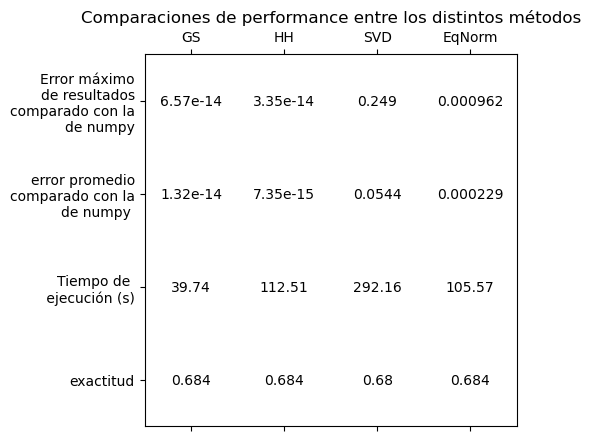

In [ ]:
data=np.zeros((4,4))

data[0][0]=f"{difProbabilidadesGR:.2e}"
data[0][1]=f"{difProbabilidadesHH:.2e}"
data[0][2]=f"{difProbabilidadesSVD:.2e}"
data[0][3]=f"{difProbabilidadesEqNorm:.2e}"

data[1][0]=f"{avgDifProbabilidadesGR:.2e}"
data[1][1]=f"{avgDifProbabilidadesHH:.2e}"
data[1][2]=f"{avgDifProbabilidadesSVD:.2e}"
data[1][3]=f"{avgDifProbabilidadesEqNorm:.2e}"

data[2][0]=f"{tiempototalgs.seconds + tiempototalgs.microseconds * 0.000001:.2f}"
data[2][1]=f"{tiempototalhh.seconds+ tiempototalhh.microseconds * 0.000001:.2f}"
data[2][2]=f"{tiempototalsvd.seconds+ tiempototalsvd.microseconds * 0.000001:.2f}"
data[2][3]=f"{tiempototaleq.seconds+ tiempototaleq.microseconds * 0.000001:.2f}"

data[3][0]=f"{round(exactitudGs,4)}"
data[3][1]=f"{round(exactitudHh,4)}"
data[3][2]=f"{round(exactitudSvd,4)}"
data[3][3]=f"{round(exactitudEq,4)}"




plt.matshow(data, cmap=matplotlib.colors.ListedColormap(['white']))
plt.title(f"Comparaciones de performance entre los distintos métodos")
plt.xticks(range(4), ["GS", "HH", "SVD", "EqNorm"])
plt.yticks(range(4), [
"""Error máximo
de resultados
comparado con la
de numpy""", 
"""
error promedio
comparado con la
de numpy 
""", 
"Tiempo de \n ejecución (s)",
 "exactitud"
])

for i ,row in enumerate(data):
    for j ,val in enumerate(row):
        plt.text(j, i, f"{val}", ha="center", va="center", color="black") 

plt.show()




# Informe del Trabajo Práctico
Integrantes:


 - Leandro Ernesto Horane Siracusa - LU: 408/24
 - Jeremías José Mannino - LU: 611/24
 - Juan Ignacio Pubill- LU: 120/24
 - Ramiro Gantman - LU: 1120/24

(estos últimos dos se bajaron de la materia poco despues del inicio del tp)

## Consideraciones tomadas

Todos los algoritmos utilizados para el cálculo de la pseudoinversa, se pudieron optimizar mediante vectorización, aprovechando los cálculos de la biblioteca numpy al hacer slicing, np.sum(), min, max etc. Nunca usamos funciones como @, .T, y otras dentro del código principal. En el notebook aparecen algunas veces para testear, pero nunca para calcular las cosas que pedía en en enunciado del TP.
Vale aclarar que las probabilidades calculadas a mano (en el alc.py) con dichos métodos son comparadas con su respectivo método de numpy (distinto para cada una), para obtener así la máxima diferencia y el promedio de ellas.

## Resultados experimentales y analisis
Las medidas de performance elegidas fueron 4:
Con respecto a la matriz de confusión se utilizó la exactitud, la cual se mide como $$(TP + TN)/(P + N)$$  
Se utilizó en segundo lugar el tiempo de ejecución de cada método. Estos fueron bastante aceptables, considerando que estan escritos en un lenguaje generalmente lento como python y comparándo con el tiempo que tardaban los métodos sin optimización.
En tercer lugar, se utilizó la diferencia máxima entre las probabilidades calculadas a mano con dichos métodos y aquellas que calcula numpy.
Por último, se utilizó el promedio diferencia máxima entre las calculadas a mano y las de numpy.
Normalmente se esperaría el siguiente orden de tiempos en calcular según los diferentes métodos:
$$ \text{Ecuaciones normales} < \text{QR por HH} < \text{QR por GS} < \text{SVD} $$
Sin embargo, en la tabla anterior podemos ver que nuestros resultados fueron diferentes. Creemos que este se debe principalmente a que algunos métodos se pueden vectorizar mas en la implementación de python con numpy usando las funciones que tenemos permitidas y otros menos.  
En esa misma tabla, se puede notar que las exactitudes son muy similares entre si, 3 de las 4 iguales. Lo sorprendente es que uno de los calculos dio suficientemente diferente al resto (recordar que la pseudoinversa es única) para que haya una predicción diferente, y más aún, es el de SVD, que se suponía que era el más estable. Creemos que esto es debido a una mala elección de tolderancia para autovalores junto a detalles de implementación.

En cuanto al máximo de las diferencias entre las probabilidades predichas por nuestro modelo y el modelo de numpy (maximo de diferencia entre cada elemento de la matriz), se ven variaciones más acentuadas. De la misma forma sucede con los promedios de estas diferencias. En ambas, SVD es el que mayor error tiene.

En conclusión, por lo menos en nuestra implementación, SVD es el peor método de los 4. Comparando HH con EqNorm, se puede observar que ambos tienen exactitud y tiempo de ejecución similares, pero HH tiene tanto error máximo como promedio del cálculo de las probabilides menor, por ende, HH es mejor. Por último, GS tiene tanto errores de probabilidades promedio como mayores a HH, y exactitud comparable. Sin embargo, tiene un tiempo de ejecución considerablemente menor, por ende es el mejor método acorde a nuestras medidas de performance.


De forma general, si se observan las matrices de confusión de cada método, se puede concluir que el modelo predice más perros que gatos, por ende se tiene un mayor acierto de perros pero también un mayor error de perros. A su vez, la precisión de los 4 métodos es cercana al 70%, lo cual no es muy bueno, pero debería ser el óptimo para una optimización lineal de cuadrados mínimos, o muy cercano a ellos. 